In [52]:
from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt

In [66]:

# Test different parameter combinations to find the smallest configuration
# that successfully finds a perfect solution (all bits = 1)
test_configs = [
    (50, 100),    # Test with population of 50, max 100 generations
    (100, 100),    # Test with population of 100, max 100 generations
   
]

# Store results from each test run
results = []

In [67]:

for POPULATION_SIZE, MAX_GENERATIONS in test_configs:
    # Print current test configuration
    print(f"\n{'='*60}")
    print(f"Testing: POPULATION_SIZE={POPULATION_SIZE}, MAX_GENERATIONS={MAX_GENERATIONS}")
    print(f"{'='*60}")


Testing: POPULATION_SIZE=50, MAX_GENERATIONS=100

Testing: POPULATION_SIZE=100, MAX_GENERATIONS=100


In [68]:
    P_CROSSOVER = 0.7  # probability for crossover
    P_MUTATION = 0.01  # probability for mutating an individual

    ONE_MAX_LENGTH = 50  
    OPTIMAL_FITNESS = ONE_MAX_LENGTH // 2  # Optimal fitness is 25 (half of 50)

    RANDOM_SEED = 42
    random.seed(RANDOM_SEED)

In [70]:

    toolbox = base.Toolbox()

    # create an operator that randomly returns 0 or 1:
    toolbox.register("zeroOrOne", random.randint, 0, 1)

    # define a single objective, maximizing fitness strategy:
    # --- DEAP CREATOR DEFINITION ---
    # Wrap in try-except to avoid RuntimeError if already created across test loops
    # Though your initial code was set up to delete it, this is safer for re-running cells
    try:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    except:
        pass # Already created
    
    try:
        # create the Individual class based on list:
        creator.create("Individual", list, fitness=creator.FitnessMax)
    except:
        pass # Already created
    # -------------------------------

    # create the individual operator to fill up an Individual instance:
    toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

    # create the population operator to generate a list of individuals:
    toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [59]:
    # HalfMax fitness function: maximum fitness when exactly 50% genes are 1
    # Linear increase from 0 to 50%, then linear decrease from 50% to 100%
    def halfMaxFitness(individual):
        """
        Fitness function that rewards having exactly 50% ones.
        - If sum <= length/2: fitness = sum (linear increase)
        - If sum > length/2: fitness = length - sum (linear decrease)
        
        Example with length=50:
        - 0 ones: fitness = 0
        - 25 ones: fitness = 25 (optimal)
        - 50 ones: fitness = 0
        """
        i = sum(individual)
        if i <= ONE_MAX_LENGTH / 2:
            return i,  # return a tuple
        else:
            return ONE_MAX_LENGTH - i,  # return a tuple

    toolbox.register("evaluate", halfMaxFitness)

In [60]:

    # genetic operators:

    # Tournament selection with tournament size of 3:
    # Randomly select 3 individuals, choose the best one
    # This is repeated to fill the mating pool
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Single-point crossover:
    toolbox.register("mate", tools.cxOnePoint)

    # Flip-bit mutation:
    # indpb: Independent probability for each attribute to be flipped
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)


In [61]:


    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0

    # calculate fitness tuple for each individual in the population:
    fitnessValues = list(map(toolbox.evaluate, population))
    for individual, fitnessValue in zip(population, fitnessValues):
        individual.fitness.values = fitnessValue

    # extract fitness values from all individuals in population:
    fitnessValues = [individual.fitness.values[0] for individual in population]

    # initialize statistics accumulators:
    maxFitnessValues = []
    meanFitnessValues = []

In [62]:



    # main evolutionary loop:
    # stop if max fitness value reached the optimal fitness (25)
    # OR if number of generations exceeded the preset value:
    while max(fitnessValues) < OPTIMAL_FITNESS and generationCounter < MAX_GENERATIONS:
        # update counter:
        generationCounter = generationCounter + 1

        # apply the selection operator, to select the next generation's individuals:
        offspring = toolbox.select(population, len(population))
        # clone the selected individuals (UNCOMMENTED - necessary for proper GA operation):
        # Without cloning, we would modify the original population directly
        offspring = list(map(toolbox.clone, offspring))

        # apply the crossover operator to pairs of offspring:
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # calculate fitness for the individuals with no previous calculated fitness value:
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
        for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
            individual.fitness.values = fitnessValue

        # replace the current population with the offspring:
        population[:] = offspring

        # collect fitnessValues into a list, update statistics and print:
        fitnessValues = [ind.fitness.values[0] for ind in population]

        maxFitness = max(fitnessValues)
        meanFitness = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitness)
        meanFitnessValues.append(meanFitness)
        print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

        # find and print best individual:
        best_index = fitnessValues.index(max(fitnessValues))
        print("Best Individual = ", *population[best_index], "\n")

In [63]:


    # A perfect solution has exactly 25 ones, so fitness = 25
    if max(fitnessValues) == OPTIMAL_FITNESS:
        # Calculate total individuals processed (population size × generations)
        individuals_processed = POPULATION_SIZE * generationCounter
        print(f"\n*** SUCCESS! Perfect solution found in generation {generationCounter}")
        print(f"*** Individuals processed: {individuals_processed} ({POPULATION_SIZE} × {generationCounter})")
        # Store result: (pop_size, max_gen, actual_gen_used, individuals_processed, success_flag)
        results.append((POPULATION_SIZE, MAX_GENERATIONS, generationCounter, individuals_processed, True))
    else:
        print(f"\n*** FAILED - Did not find perfect solution within {MAX_GENERATIONS} generations")
        print(f"*** Best fitness achieved: {max(fitnessValues)} out of {OPTIMAL_FITNESS}")
        # Store failed result
        results.append((POPULATION_SIZE, MAX_GENERATIONS, generationCounter, None, False))
    


*** SUCCESS! Perfect solution found in generation 0
*** Individuals processed: 0 (800 × 0)


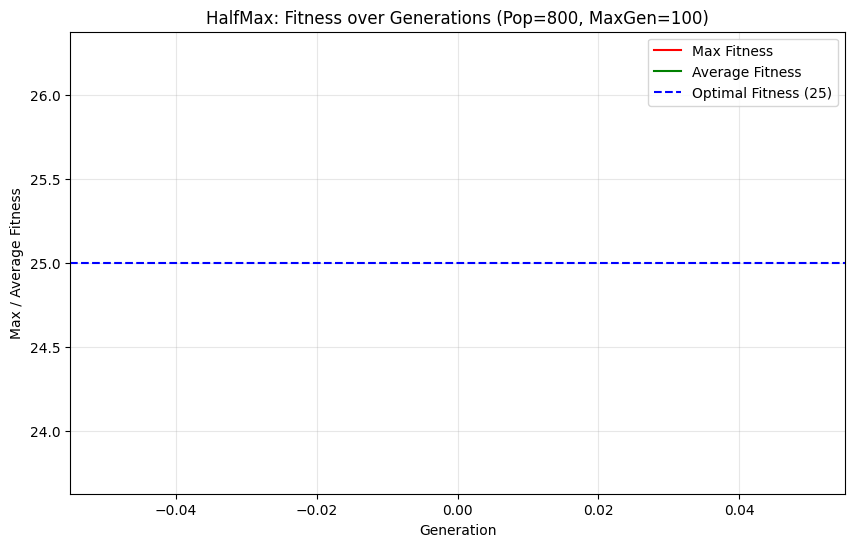

In [65]:


    # Genetic Algorithm is done - plot statistics:
    #sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(maxFitnessValues, color='red', label='Max Fitness')
    plt.plot(meanFitnessValues, color='green', label='Average Fitness')
    plt.axhline(y=OPTIMAL_FITNESS, color='blue', linestyle='--', label='Optimal Fitness (25)')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title(f'HalfMax: Fitness over Generations (Pop={POPULATION_SIZE}, MaxGen={MAX_GENERATIONS})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Clean up DEAP creators for next iteration
    # This is necessary to avoid conflicts when testing multiple configurations
    # FIX: Use try...except to prevent AttributeError on subsequent loops
    try:
        del creator.FitnessMax
        del creator.Individual
    except AttributeError:
        pass # Ignore if already deleted
